In [1]:
# Install pytorch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [2]:
from __future__ import division
from __future__ import unicode_literals
import os
# import os.path as osp
import numpy as np
import pandas as pd
import sympy as sym
import torch
import datetime
import math
from math import sqrt, pi as PI
from tqdm import tqdm

import torch.nn as nn
from torch.nn import Linear, Embedding

import torch.optim as optim

from torch_sparse import SparseTensor
from torch_scatter import scatter
import torch_cluster

from torch_geometric.nn import radius_graph
from torch_geometric.nn.acts import swish
from torch_geometric.nn.inits import glorot_orthogonal
from torch_geometric.nn.models.dimenet_utils import bessel_basis, real_sph_harm

from torch_geometric.data import Data, DataLoader

from sklearn.metrics import r2_score, mean_absolute_error as MAE
from torch.optim.optimizer import Optimizer, required
import torch

from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({'font.size': 20})

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Envelope(torch.nn.Module):
    def __init__(self, exponent):
        super(Envelope, self).__init__()
        self.p = exponent + 1
        self.a = -(self.p + 1) * (self.p + 2) / 2
        self.b = self.p * (self.p + 2)
        self.c = -self.p * (self.p + 1) / 2

    def forward(self, x):
        p, a, b, c = self.p, self.a, self.b, self.c
        x_pow_p0 = x.pow(p - 1)
        x_pow_p1 = x_pow_p0 * x
        x_pow_p2 = x_pow_p1 * x
        return 1. / x + a * x_pow_p0 + b * x_pow_p1 + c * x_pow_p2


class BesselBasisLayer(torch.nn.Module):
    def __init__(self, num_radial, cutoff=5.0, envelope_exponent=5):
        super(BesselBasisLayer, self).__init__()
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        # Initialize frequencies at canonical positions
        self.freq = torch.nn.Parameter(torch.Tensor(num_radial))

        self.reset_parameters()

    def reset_parameters(self):
        torch.arange(1, self.freq.numel() + 1, out=self.freq).mul_(PI)

    def forward(self, dist):
        dist = dist.unsqueeze(-1) / self.cutoff
        return self.envelope(dist) * (self.freq * dist).sin()


class SphericalBasisLayer(torch.nn.Module):
    def __init__(self, num_spherical, num_radial, cutoff=5.0,
                 envelope_exponent=5):
        super(SphericalBasisLayer, self).__init__()
        assert num_radial <= 64
        self.num_spherical = num_spherical
        self.num_radial = num_radial
        self.cutoff = cutoff
        self.envelope = Envelope(envelope_exponent)

        bessel_forms = bessel_basis(num_spherical, num_radial)
        sph_harm_forms = real_sph_harm(num_spherical)
        self.sph_funcs = []
        self.bessel_funcs = []

        x, theta = sym.symbols('x theta')
        modules = {'sin': torch.sin, 'cos': torch.cos}
        for i in range(num_spherical):
            if i == 0:
                sph1 = sym.lambdify([theta], sph_harm_forms[i][0], modules)(0)
                self.sph_funcs.append(lambda x: torch.zeros_like(x) + sph1)
            else:
                sph = sym.lambdify([theta], sph_harm_forms[i][0], modules)
                self.sph_funcs.append(sph)
            for j in range(num_radial):
                bessel = sym.lambdify([x], bessel_forms[i][j], modules)
                self.bessel_funcs.append(bessel)

    def forward(self, dist, angle, idx_kj):
        dist = dist / self.cutoff
        rbf = torch.stack([f(dist) for f in self.bessel_funcs], dim=1)
        rbf = self.envelope(dist).unsqueeze(-1) * rbf

        cbf = torch.stack([f(angle) for f in self.sph_funcs], dim=1)

        n, k = self.num_spherical, self.num_radial
        out = (rbf[idx_kj].view(-1, n, k) * cbf.view(-1, n, 1)).view(-1, n * k)
        return out


class Embedder(nn.Module):
    def __init__(self,
                 d_model,
                 compute_device=None):
        super().__init__()
        self.d_model = d_model
        self.compute_device = torch.device('cuda')

        # mat2vec element embeddings
        cbfv = pd.read_csv('drive/My Drive/DimeNet/mat2vec.csv',
                           index_col=0).values
        feat_size = cbfv.shape[-1]
        self.fc_mat2vec = nn.Linear(feat_size,
                                    self.d_model).to(self.compute_device)
        zeros = np.zeros((1, feat_size))
        cat_array = np.concatenate([zeros, cbfv])
        cat_array = torch.as_tensor(cat_array, dtype=torch.float)
        self.cbfv = nn.Embedding.from_pretrained(cat_array) \
            .to(self.compute_device, dtype=torch.float)

    def forward(self, src, i):
        mat2vec_emb = self.cbfv(src)  # src is tensor of z
        x_emb = self.fc_mat2vec(mat2vec_emb[i])  # put it through the network
        return x_emb  # the 128 thing (hidden_channels)


class EmbeddingBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, act=swish):
        super(EmbeddingBlock, self).__init__()
        self.act = act

        self.emb = Embedding(119, hidden_channels)
        self.lin_rbf = Linear(num_radial, hidden_channels)
        self.lin = Linear(3 * hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.emb.weight.data.uniform_(-sqrt(3), sqrt(3))
        self.lin_rbf.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x, rbf, i, j):
        x = self.emb(x)
        rbf = self.act(self.lin_rbf(rbf))
        return self.act(self.lin(torch.cat([x[i], x[j], rbf], dim=-1)))


class ResidualLayer(torch.nn.Module):
    def __init__(self, hidden_channels, act=swish):
        super(ResidualLayer, self).__init__()
        self.act = act
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin1.weight, scale=2.0)
        self.lin1.bias.data.fill_(0)
        glorot_orthogonal(self.lin2.weight, scale=2.0)
        self.lin2.bias.data.fill_(0)

    def forward(self, x):
        return x + self.act(self.lin2(self.act(self.lin1(x))))


class InteractionBlock(torch.nn.Module):
    def __init__(self, hidden_channels, int_emb_size, basis_emb_size,
                 num_bilinear, num_spherical, num_radial, num_before_skip,
                 num_after_skip, act=swish):
        super(InteractionBlock, self).__init__()
        self.act = act

        # Transformations of Bessel and spherical basis representations
        self.lin_rbf1 = Linear(num_radial, basis_emb_size, bias=False)
        self.lin_rbf2 = Linear(basis_emb_size, hidden_channels, bias=False)

        self.lin_sbf1 = Linear(num_radial * num_spherical, basis_emb_size,
                               bias=False)
        self.lin_sbf2 = Linear(basis_emb_size, int_emb_size,
                               bias=False)

        # Dense transformations of input messages.
        self.lin_kj = Linear(hidden_channels, hidden_channels)
        self.lin_ji = Linear(hidden_channels, hidden_channels)

        # Embedding projections for interaction triplets
        self.down_projection = Linear(hidden_channels, int_emb_size,
                                      bias=False)
        self.up_projection = Linear(int_emb_size, hidden_channels, bias=False)

        # Residual layers before skip connection
        self.layers_before_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_before_skip)
        ])
        self.lin = Linear(hidden_channels, hidden_channels)  # last before skip

        # Residual layers after skip connection
        self.layers_after_skip = torch.nn.ModuleList([
            ResidualLayer(hidden_channels, act) for _ in range(num_after_skip)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf1.weight, scale=2.0)
        glorot_orthogonal(self.lin_rbf2.weight, scale=2.0)
        glorot_orthogonal(self.lin_sbf1.weight, scale=2.0)
        glorot_orthogonal(self.lin_sbf2.weight, scale=2.0)

        glorot_orthogonal(self.lin_kj.weight, scale=2.0)
        self.lin_kj.bias.data.fill_(0)
        glorot_orthogonal(self.lin_ji.weight, scale=2.0)
        self.lin_ji.bias.data.fill_(0)

        glorot_orthogonal(self.down_projection.weight, scale=2.0)
        glorot_orthogonal(self.up_projection.weight, scale=2.0)

        for res_layer in self.layers_before_skip:
            res_layer.reset_parameters()
        glorot_orthogonal(self.lin.weight, scale=2.0)
        self.lin.bias.data.fill_(0)
        for res_layer in self.layers_after_skip:
            res_layer.reset_parameters()

    def forward(self, x, rbf, sbf, idx_kj, idx_ji):
        # Initial transformation
        x_ji = self.act(self.lin_ji(x))
        x_kj = self.act(self.lin_kj(x))

        # Transform via Bessel basis
        rbf = self.lin_rbf1(rbf)
        rbf = self.lin_rbf2(rbf)
        x_kj = x_kj * rbf

        # Down-project embeddings and generate interaction triplet embeddings
        x_kj = self.act(self.down_projection(x_kj))

        # Transform via 2D spherical basis
        sbf = self.lin_sbf1(sbf)
        sbf = self.lin_sbf2(sbf)
        x_kj = x_kj[idx_kj] * sbf

        # Aggregate interactions and up-project embeddings
        x_kj = scatter(x_kj, idx_ji, dim=0, dim_size=x.size(0))
        x_kj = self.up_projection(x_kj)

        # Transformations before skip connection
        h = x_ji + x_kj
        for layer in self.layers_before_skip:
            h = layer(h)
        h = self.act(self.lin(h)) + x

        # Transformations after skip connection
        for layer in self.layers_after_skip:
            h = layer(h)

        return h


class OutputBlock(torch.nn.Module):
    def __init__(self, num_radial, hidden_channels, out_emb_size,
                 out_channels, num_layers, act=swish):
        super(OutputBlock, self).__init__()
        self.act = act

        self.lin_rbf = Linear(num_radial, hidden_channels, bias=False)

        self.up_projection = Linear(hidden_channels, out_emb_size, bias=False)

        self.lins = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.lins.append(Linear(out_emb_size, out_emb_size))
        self.lin = Linear(out_emb_size, out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        glorot_orthogonal(self.lin_rbf.weight, scale=2.0)
        glorot_orthogonal(self.up_projection.weight, scale=2.0)
        for lin in self.lins:
            glorot_orthogonal(lin.weight, scale=2.0)
            lin.bias.data.fill_(0)
        self.lin.weight.data.fill_(0)

    def forward(self, x, rbf, i, num_nodes=None):
        x = self.lin_rbf(rbf) * x
        # print("outputblock x:", x.shape)
        x = scatter(x, i, dim=0, dim_size=num_nodes)
        # print("outputblock x:", x.shape)
        x = self.up_projection(x)
        # print("outputblock x:", x.shape)

        for lin in self.lins:
            x = self.act(lin(x))
        return self.lin(x)


class DimeNet(torch.nn.Module):
    r"""The directional message passing neural network (DimeNet) from the
    `"Directional Message Passing for Molecular Graphs"
    <https://arxiv.org/abs/2003.03123>`_ paper.
    DimeNet transforms messages based on the angle between them in a
    rotation-equivariant fashion.
    .. note::
        For an example of using a pretrained DimeNet variant, see
        `examples/qm9_pretrained_dimenet.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        qm9_pretrained_dimenet.py>`_.
    Args:
        hidden_channels (int): Hidden embedding size.
        out_channels (int): Size of each output sample.
        num_blocks (int): Number of building blocks.
        num_bilinear (int): Size of the bilinear layer tensor.
        num_spherical (int): Number of spherical harmonics.
        num_radial (int): Number of radial basis functions.
        cutoff: (float, optional): Cutoff distance for interatomic
            interactions. (default: :obj:`5.0`)
        envelope_exponent (int, optional): Shape of the smooth cutoff.
            (default: :obj:`5`)
        num_before_skip: (int, optional): Number of residual layers in the
            interaction blocks before the skip connection. (default: :obj:`1`)
        num_after_skip: (int, optional): Number of residual layers in the
            interaction blocks after the skip connection. (default: :obj:`2`)
        num_output_layers: (int, optional): Number of linear layers for the
            output blocks. (default: :obj:`3`)
        act: (function, optional): The activation funtion.
            (default: :obj:`swish`)
    """

    def __init__(self, hidden_channels, out_channels, num_blocks, num_bilinear,
                 out_emb_size, int_emb_size, basis_emb_size, num_spherical,
                 num_radial, cutoff=5.0, envelope_exponent=5,
                 num_before_skip=1, num_after_skip=2, num_output_layers=3,
                 act=swish):
        super(DimeNet, self).__init__()

        self.cutoff = cutoff

        if sym is None:
            raise ImportError('Package `sympy` could not be found.')

        self.num_blocks = num_blocks

        # Cosine basis function expansion layer
        self.rbf = BesselBasisLayer(num_radial, cutoff, envelope_exponent)
        self.sbf = SphericalBasisLayer(num_spherical, num_radial, cutoff,
                                       envelope_exponent)

        # Embedding and output blocks
        self.emb = EmbeddingBlock(num_radial, hidden_channels, act)
        self.element_emb = Embedder(hidden_channels)

        self.output_blocks = torch.nn.ModuleList([
            OutputBlock(num_radial, hidden_channels, out_emb_size,
                        out_channels,
                        num_output_layers, act) for _ in range(num_blocks + 1)
        ])
        self.scaler = nn.parameter.Parameter(torch.tensor([1.]))

        # Interaction blocks
        self.interaction_blocks = torch.nn.ModuleList([
            InteractionBlock(hidden_channels,
                             int_emb_size,
                             basis_emb_size,
                             num_bilinear, num_spherical,
                             num_radial, num_before_skip, num_after_skip, act)
            for _ in range(num_blocks)
        ])

        self.reset_parameters()

    def reset_parameters(self):
        self.rbf.reset_parameters()
        self.emb.reset_parameters()
        for out in self.output_blocks:
            out.reset_parameters()
        for interaction in self.interaction_blocks:
            interaction.reset_parameters()

    def triplets(self, edge_index, num_nodes):
        row, col = edge_index  # j->i

        value = torch.arange(row.size(0), device=row.device)
        adj_t = SparseTensor(row=col, col=row, value=value,
                             sparse_sizes=(num_nodes, num_nodes))
        adj_t_row = adj_t[row]
        num_triplets = adj_t_row.set_value(None).sum(dim=1).to(torch.long)

        # Node indices (k->j->i) for triplets.
        idx_i = col.repeat_interleave(num_triplets)
        idx_j = row.repeat_interleave(num_triplets)
        idx_k = adj_t_row.storage.col()
        mask = idx_i != idx_k  # Remove i == k triplets.
        idx_i, idx_j, idx_k = idx_i[mask], idx_j[mask], idx_k[mask]

        # Edge indices (k-j, j->i) for triplets.
        idx_kj = adj_t_row.storage.value()[mask]
        idx_ji = adj_t_row.storage.row()[mask]

        return col, row, idx_i, idx_j, idx_k, idx_kj, idx_ji

    def forward(self, z, pos, batch=None):
        edge_index = radius_graph(pos, r=self.cutoff, batch=batch)

        i, j, idx_i, idx_j, idx_k, idx_kj, idx_ji = self.triplets(
            edge_index, num_nodes=z.size(0))

        # Calculate distances.
        dist = (pos[i] - pos[j]).pow(2).sum(dim=-1).sqrt()

        # Calculate angles -- revised version
        pos_i = pos[idx_i]
        pos_j = pos[idx_j]
        pos_k = pos[idx_k]

        pos_ji = pos_j - pos_i
        pos_kj = pos_k - pos_j

        a = (pos_ji * pos_kj).sum(dim=-1)
        b = torch.cross(pos_ji, pos_kj).norm(dim=-1)
        angle = torch.atan2(b, a)

        rbf = self.rbf(dist)
        # print('rbf shape', rbf.shape)
        sbf = self.sbf(dist, angle, idx_kj)

        # Embedding block.
        x = self.emb(z, rbf, i, j)  # embed atomic numbers
        ebfv = self.element_emb(z, i) * (2**(1-self.scaler)**2)  # mat2vec
        x = x + ebfv  # atomic numbers now have domain-relevant features

        P = self.output_blocks[0](x, rbf, i, num_nodes=pos.size(0))

        # Interaction blocks.
        for interaction_block, output_block in zip(self.interaction_blocks,
                                                   self.output_blocks[1:]):
            x = interaction_block(x, rbf, sbf, idx_kj, idx_ji)
            P += output_block(x, rbf, i)

        return P.sum(dim=0) if batch is None else scatter(P, batch, dim=0)

In [5]:
# validation inference loop
def val_inference(model, loader):
    y_preds = []
    y_actual = []

    for data in tqdm(loader, leave=False):
        data = data.to(device)

        # get prediction
        with torch.no_grad():
            pred = model(data.z, data.pos, data.batch)

        y_preds.append(pred.view(-1))
        y_actual.append(data.y)

    y_preds = torch.cat(y_preds, dim=0).detach().cpu()
    y_actual = torch.cat(y_actual, dim=0).detach().cpu()

    mae = MAE(y_actual, y_preds)
    r2 = r2_score(y_actual, y_preds)

    print()
    print(f'Validating... '
          f'MAE: {mae:.3f}, '
          f'R2: {r2:.3f} on val_dataset, '
          f'completed at {datetime.datetime.now().strftime("%H:%M")}')
    return y_actual, y_preds, mae, r2


# test inference loop
def test_inference(model, loader):
    y_test, y_test_pred, mae, r2 = val_inference(model, loader)
    print(f'\nTest Results:\tMAE: {mae:.3f}, R2: {r2:.3f}')
    return y_test.numpy(), y_test_pred.numpy(), mae, r2

In [6]:
def act_pred(y_act, y_pred, target, r2, mae,
             name='example',
             x_hist=True,
             y_hist=True,
             save_dir=None):

    mec = '#2F4F4F'
    mfc = '#C0C0C0'

    plt.figure(1, figsize=(6, 6), dpi=300)
    left, width = 0.1, 0.65

    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15, height]

    ax2 = plt.axes(rect_scatter)
    ax2.tick_params(direction='in',
                    length=7,
                    top=True,
                    right=True)

    # add minor ticks
    minor_locator_x = AutoMinorLocator(2)
    minor_locator_y = AutoMinorLocator(2)
    ax2.get_xaxis().set_minor_locator(minor_locator_x)
    ax2.get_yaxis().set_minor_locator(minor_locator_y)
    plt.tick_params(which='minor',
                    direction='in',
                    length=4,
                    right=True,
                    top=True)

    ax2.plot(y_act, y_pred, 'o', mfc='lightblue', alpha=0.5, label=None,
             mec='dimgrey', mew=1.2, ms=7)
    ax2.plot([-10**9, 10**9], [-10**9, 10**9], 'k--', alpha=0.8, lw=1.5,
             label='Ideal')

    label_units = {'matbench_jdft2d': 'E Exfol. [eV/atom]',
                   'matbench_phonons': 'PhDOS Peak [1/cm]',
                   'matbench_dielectric': '$n$',
                   'matbench_log_kvrh': 'log$(K)$ [log(GPa)]',
                   'matbench_log_gvrh': 'log$(G)$ [log(GPa)]',
                   'matbench_perovskites': '$E_{form}$ [eV]',
                   'matbench_mp_gap': '$E_{g}$ [eV]',
                   'matbench_mp_is_metal': 'Metallicity',
                   'matbench_mp_e_form': '$E_{form}$ [eV/atom]'}
    lab = label_units[target]

    ax2.set_ylabel(f'Predicted {lab}')
    ax2.set_xlabel(f'Actual {lab}')
    x_range = max(y_act) - min(y_act)
    ax2.set_xlim(max(y_act) - x_range*1.05,
                 min(y_act) + x_range*1.05)

    ax2.set_ylim(max(y_act) - x_range*1.05,
                 min(y_act) + x_range*1.05)

    ax1 = plt.axes(rect_histx)
    ax1_n, ax1_bins, ax1_patches = ax1.hist(y_act,
                                            bins=31,
                                            density=True,
                                            color=mfc,
                                            edgecolor='black',
                                            alpha=0)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlim(ax2.get_xlim())
    ax1.axis('off')

    if x_hist:
        [p.set_alpha(1.0) for p in ax1_patches]

    ax3 = plt.axes(rect_histy)
    ax3_n, ax3_bins, ax3_patches = ax3.hist(y_pred,
                                            bins=31,
                                            density=True,
                                            color=mfc,
                                            edgecolor='black',
                                            orientation='horizontal',
                                            alpha=0)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_ylim(ax2.get_ylim())
    ax3.axis('off')

    if y_hist:
        [p.set_alpha(1.0) for p in ax3_patches]
    
    max_ax_val = min(y_act) + x_range*1.05
    x_ = .05 * max_ax_val
    y_ = .82 * max_ax_val
    y_2 = .9 * max_ax_val

    ax2.text(x_, y_2, f'$R^2={r2:.4f}$')
    ax2.text(x_, y_, f'MAE$={mae:.4f}$')
    ax2.legend(loc='lower right', framealpha=0.35, handlelength=1.5)
    plt.draw()

    if save_dir is not None:
        fig_name = f'{save_dir}/{name}_act_pred.png'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    plt.show()

In [7]:
def loss_curve(x_data, train_err, val_err, name='example', save_dir=None):

    mec1 = 'black'
    mfc1 = '#003f5c'
    mec2 = 'maroon'
    mfc2 = 'pink'

    fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
    ax.plot(x_data, train_err, '-', lw=2, color='#003f5c', alpha=0.8,
            label='train')
    ax.plot(x_data, val_err, '-', color=mec2, lw=2, alpha=0.9,
            label='validation')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 2 * np.mean(val_err))

    ax.legend(loc=1, framealpha=0.35, handlelength=1.5)

    minor_locator_x = AutoMinorLocator(2)
    minor_locator_y = AutoMinorLocator(2)
    ax.get_xaxis().set_minor_locator(minor_locator_x)
    ax.get_yaxis().set_minor_locator(minor_locator_y)

    ax.tick_params(right=True,
                   top=True,
                   direction='in',
                   length=7)
    ax.tick_params(which='minor',
                   right=True,
                   top=True,
                   direction='in',
                   length=4)

    if save_dir is not None:
        fig_name = f'{save_dir}/{name}_loss_curve.png'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    plt.show()

In [8]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [9]:
criterion = nn.L1Loss()

device = torch.device('cuda')

datasets = ['matbench_jdft2d', 'matbench_phonons', 'matbench_dielectric',
            'matbench_log_kvrh', 'matbench_log_gvrh', 'matbench_perovskites',
            'matbench_mp_gap', 'matbench_mp_is_metal', 'matbench_mp_e_form']

dataset = 'matbench_log_gvrh'
path = 'drive/My Drive/DimeNet/eighty_atoms'

full_data = np.load(f'{path}/{dataset}.npy',
                    allow_pickle=True).tolist()

new_data = []
for cif in full_data:
    # n = cif['N']
    # formula = cif['formula']
    pos = cif['R']
    z = cif['Z']
    y = cif['Y']
    new_data.append(Data(
        z=torch.tensor(z, dtype=torch.long).reshape(-1),
        y=torch.tensor(y, dtype=torch.float),
        # n=torch.tensor(n, dtype=torch.long).reshape(-1),
        pos=torch.tensor(pos, dtype=torch.float),
        # formula=formula
        ))

# 60/20/20 split for the training, validation, and test dataset
random_state = np.random.RandomState(seed=0)
length = len(new_data)
a = round(0.6 * length)
b = round(0.2 * length)
perm = list(random_state.permutation(np.arange(len(new_data))))
train_idx = perm[:a]
val_idx = perm[a:a+b]
test_idx = perm[a+b:]

mat_train = [new_data[i] for i in train_idx]
mat_val = [new_data[i] for i in val_idx]
mat_test = [new_data[i] for i in test_idx]

materials_data = mat_train

model = DimeNet(hidden_channels=128, out_channels=1, num_blocks=4,
                num_bilinear=8,
                out_emb_size=256, int_emb_size=64, basis_emb_size=8,
                num_spherical=7, num_radial=6,
                cutoff=6.0, envelope_exponent=5, num_before_skip=1,
                num_after_skip=2, num_output_layers=3)

model = model.to(device)

In [10]:
epochs = 100
batch_size = 16
loader = DataLoader(materials_data, batch_size=batch_size)
val_loader = DataLoader(mat_val, batch_size=batch_size)

In [11]:
optimizer = optim.AdamW(model.parameters(),
                        weight_decay=0.01, amsgrad=True)

# optimizer = Ranger(model.parameters(), weight_decay=0.01)
gammas = {'matbench_jdft2d': 0.998,
          'matbench_phonons': 0.999,
          'matbench_log_kvrh': 0.99993,
          'matbench_log_gvrh': 0.99993}

lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer,
                                           base_lr=1e-4,
                                           max_lr=2e-3,
                                           cycle_momentum=False,
                                           mode='exp_range',
                                           gamma=0.99993,
                                        #    mode='triangular2',
                                           step_size_up=4*len(loader))
# n * len(loader) means it'll take n epochs in the step-up (half triangle)

In [12]:
print(f'Started training at {datetime.datetime.now().strftime("%H:%M")}')
print("See you in 10 years (ノ͡° ͜ʖ ͡°)ノ︵┻┻\n")

r2_train = []
mae_train = []

r2_val = []
mae_val = []

e = []
rates = []

for epoch in range(1, epochs + 1):  # unlike targets, indexing starts at 1

    y_preds = []
    y_actual = []

    # lr_scheduler.step()
    # if epoch >= 0.5 * epochs:
    #     lr_scheduler.step()

    for data in tqdm(loader, leave=False, total=len(loader)):
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data.z, data.pos, data.batch)

        y_preds.append(pred.view(-1))
        y_actual.append(data.y)

        loss = criterion(pred.view(-1), data.y)
        loss.backward()
        optimizer.step()
        rates.append(lr_scheduler.get_last_lr())
        if epoch <= 96:
            lr_scheduler.step()
        # warmup_scheduler.dampen()

    y_preds = torch.cat(y_preds, dim=0).detach().cpu()
    y_actual = torch.cat(y_actual, dim=0).detach().cpu()

    r2 = r2_score(y_actual, y_preds)
    mae = MAE(y_actual, y_preds)

    r2_train.append(r2)
    mae_train.append(mae)
    e.append(epoch)
    print()
    print(f'Epoch: {epoch:02d}, '
          f'MAE: {mae:.3f}, '
          f'R2: {r2:.3f}, '
          f'completed at {datetime.datetime.now().strftime("%H:%M")}')

    # validation inference
    y_val, y_val_pred, mae_v, r2_v = val_inference(model, val_loader)
    mae_val.append(mae_v)
    r2_val.append(r2_v)

    date = datetime.date.today().strftime('%m-%d')
    if epoch % 20 == 0:
        print(f'Saved model weights for epoch {epoch}')
        path = 'drive/My Drive/DimeNet/saves/model'
        torch.save(model.state_dict(),
                    f'{path}/{dataset}/model_{date}_{epoch}.pt')
        torch.save(optimizer.state_dict(),
                    f'{path}/{dataset}/optimizer_{date}_{epoch}.pt')
        torch.save(lr_scheduler.state_dict(),
                    f'{path}/{dataset}/lrscheduler_{date}_{epoch}.pt')


  0%|          | 0/412 [00:00<?, ?it/s]

Started training at 02:25
See you in 10 years (ノ͡° ͜ʖ ͡°)ノ︵┻┻



  1%|▏         | 2/138 [00:00<00:09, 14.90it/s]


Epoch: 01, MAE: 0.256, R2: 0.088, completed at 02:27


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.261, R2: 0.259 on val_dataset, completed at 02:27


  1%|▏         | 2/138 [00:00<00:08, 15.18it/s]


Epoch: 02, MAE: 0.211, R2: 0.466, completed at 02:29


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.229, R2: 0.415 on val_dataset, completed at 02:29


  1%|▏         | 2/138 [00:00<00:09, 14.93it/s]


Epoch: 03, MAE: 0.177, R2: 0.615, completed at 02:30


  0%|          | 1/412 [00:00<01:21,  5.05it/s]


Validating... MAE: 0.139, R2: 0.743 on val_dataset, completed at 02:31


  1%|▏         | 2/138 [00:00<00:09, 15.07it/s]


Epoch: 04, MAE: 0.159, R2: 0.673, completed at 02:32


  0%|          | 1/412 [00:00<01:21,  5.02it/s]


Validating... MAE: 0.172, R2: 0.649 on val_dataset, completed at 02:32


  1%|▏         | 2/138 [00:00<00:08, 15.18it/s]


Epoch: 05, MAE: 0.143, R2: 0.732, completed at 02:34


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.148, R2: 0.766 on val_dataset, completed at 02:34


  1%|▏         | 2/138 [00:00<00:08, 15.16it/s]


Epoch: 06, MAE: 0.119, R2: 0.808, completed at 02:36


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.119, R2: 0.835 on val_dataset, completed at 02:36


  1%|▏         | 2/138 [00:00<00:08, 15.15it/s]


Epoch: 07, MAE: 0.100, R2: 0.855, completed at 02:37


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.105, R2: 0.858 on val_dataset, completed at 02:37


  1%|▏         | 2/138 [00:00<00:09, 14.86it/s]


Epoch: 08, MAE: 0.086, R2: 0.883, completed at 02:39


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.876 on val_dataset, completed at 02:39


  1%|▏         | 2/138 [00:00<00:09, 14.91it/s]


Epoch: 09, MAE: 0.082, R2: 0.892, completed at 02:41


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.867 on val_dataset, completed at 02:41


  1%|▏         | 2/138 [00:00<00:08, 15.19it/s]


Epoch: 10, MAE: 0.090, R2: 0.877, completed at 02:43


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.103, R2: 0.859 on val_dataset, completed at 02:43


  1%|▏         | 2/138 [00:00<00:09, 15.02it/s]


Epoch: 11, MAE: 0.095, R2: 0.869, completed at 02:44


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.104, R2: 0.850 on val_dataset, completed at 02:44


  1%|▏         | 2/138 [00:00<00:08, 15.11it/s]


Epoch: 12, MAE: 0.101, R2: 0.856, completed at 02:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.115, R2: 0.831 on val_dataset, completed at 02:46


  1%|▏         | 2/138 [00:00<00:09, 15.02it/s]


Epoch: 13, MAE: 0.103, R2: 0.855, completed at 02:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.101, R2: 0.853 on val_dataset, completed at 02:48


  1%|▏         | 2/138 [00:00<00:09, 14.74it/s]


Epoch: 14, MAE: 0.089, R2: 0.882, completed at 02:49


  0%|          | 1/412 [00:00<01:21,  5.05it/s]


Validating... MAE: 0.099, R2: 0.863 on val_dataset, completed at 02:50


  1%|▏         | 2/138 [00:00<00:08, 15.12it/s]


Epoch: 15, MAE: 0.079, R2: 0.903, completed at 02:51


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.877 on val_dataset, completed at 02:51


  1%|▏         | 2/138 [00:00<00:09, 14.42it/s]


Epoch: 16, MAE: 0.069, R2: 0.920, completed at 02:53


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.884 on val_dataset, completed at 02:53


  1%|▏         | 2/138 [00:00<00:09, 14.99it/s]


Epoch: 17, MAE: 0.066, R2: 0.925, completed at 02:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.882 on val_dataset, completed at 02:55


  1%|▏         | 2/138 [00:00<00:09, 14.91it/s]


Epoch: 18, MAE: 0.071, R2: 0.918, completed at 02:56


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.102, R2: 0.864 on val_dataset, completed at 02:57


  1%|▏         | 2/138 [00:00<00:08, 15.22it/s]


Epoch: 19, MAE: 0.076, R2: 0.909, completed at 02:58


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.874 on val_dataset, completed at 02:58


  1%|▏         | 2/138 [00:00<00:09, 15.02it/s]


Epoch: 20, MAE: 0.082, R2: 0.898, completed at 03:00



Validating... MAE: 0.115, R2: 0.839 on val_dataset, completed at 03:00
Saved model weights for epoch 20


  1%|▏         | 2/138 [00:00<00:09, 14.98it/s]


Epoch: 21, MAE: 0.087, R2: 0.790, completed at 03:02


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.109, R2: 0.828 on val_dataset, completed at 03:02


  1%|▏         | 2/138 [00:00<00:08, 15.12it/s]


Epoch: 22, MAE: 0.085, R2: 0.892, completed at 03:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.871 on val_dataset, completed at 03:04


  1%|▏         | 2/138 [00:00<00:09, 14.92it/s]


Epoch: 23, MAE: 0.071, R2: 0.920, completed at 03:05


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.883 on val_dataset, completed at 03:05


  1%|▏         | 2/138 [00:00<00:09, 15.07it/s]


Epoch: 24, MAE: 0.061, R2: 0.935, completed at 03:07


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.087, R2: 0.886 on val_dataset, completed at 03:07


  1%|▏         | 2/138 [00:00<00:08, 15.18it/s]


Epoch: 25, MAE: 0.056, R2: 0.941, completed at 03:09


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.882 on val_dataset, completed at 03:09


  1%|▏         | 2/138 [00:00<00:09, 14.86it/s]


Epoch: 26, MAE: 0.060, R2: 0.936, completed at 03:10


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.879 on val_dataset, completed at 03:11


  1%|▏         | 2/138 [00:00<00:09, 14.79it/s]


Epoch: 27, MAE: 0.066, R2: 0.929, completed at 03:12


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.872 on val_dataset, completed at 03:12


  1%|▏         | 2/138 [00:00<00:09, 15.08it/s]


Epoch: 28, MAE: 0.071, R2: 0.921, completed at 03:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.104, R2: 0.863 on val_dataset, completed at 03:14


  1%|▏         | 2/138 [00:00<00:09, 14.41it/s]


Epoch: 29, MAE: 0.070, R2: 0.923, completed at 03:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.869 on val_dataset, completed at 03:16


  1%|▏         | 2/138 [00:00<00:09, 15.11it/s]


Epoch: 30, MAE: 0.065, R2: 0.932, completed at 03:17


  0%|          | 1/412 [00:00<01:21,  5.03it/s]


Validating... MAE: 0.090, R2: 0.880 on val_dataset, completed at 03:17


  1%|▏         | 2/138 [00:00<00:09, 15.08it/s]


Epoch: 31, MAE: 0.058, R2: 0.943, completed at 03:19


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.886 on val_dataset, completed at 03:19


  1%|▏         | 2/138 [00:00<00:09, 15.11it/s]


Epoch: 32, MAE: 0.052, R2: 0.951, completed at 03:21


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.881 on val_dataset, completed at 03:21


  1%|▏         | 2/138 [00:00<00:08, 15.11it/s]


Epoch: 33, MAE: 0.048, R2: 0.956, completed at 03:23


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.882 on val_dataset, completed at 03:23


  1%|▏         | 2/138 [00:00<00:09, 14.72it/s]


Epoch: 34, MAE: 0.050, R2: 0.954, completed at 03:24


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.875 on val_dataset, completed at 03:24


  1%|▏         | 2/138 [00:00<00:08, 15.38it/s]


Epoch: 35, MAE: 0.053, R2: 0.950, completed at 03:26


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.879 on val_dataset, completed at 03:26


  1%|▏         | 2/138 [00:00<00:09, 15.05it/s]


Epoch: 36, MAE: 0.058, R2: 0.944, completed at 03:28


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.095, R2: 0.870 on val_dataset, completed at 03:28


  1%|▏         | 2/138 [00:00<00:09, 14.59it/s]


Epoch: 37, MAE: 0.061, R2: 0.941, completed at 03:30


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.863 on val_dataset, completed at 03:30


  1%|▏         | 2/138 [00:00<00:09, 14.87it/s]


Epoch: 38, MAE: 0.057, R2: 0.947, completed at 03:31


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.883 on val_dataset, completed at 03:31


  1%|▏         | 2/138 [00:00<00:08, 15.19it/s]


Epoch: 39, MAE: 0.050, R2: 0.955, completed at 03:33


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.882 on val_dataset, completed at 03:33


  1%|▏         | 2/138 [00:00<00:09, 14.86it/s]


Epoch: 40, MAE: 0.045, R2: 0.961, completed at 03:35



Validating... MAE: 0.088, R2: 0.883 on val_dataset, completed at 03:35
Saved model weights for epoch 40


  1%|▏         | 2/138 [00:00<00:09, 15.06it/s]


Epoch: 41, MAE: 0.040, R2: 0.966, completed at 03:37


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.883 on val_dataset, completed at 03:37


  1%|▏         | 2/138 [00:00<00:09, 14.97it/s]


Epoch: 42, MAE: 0.041, R2: 0.965, completed at 03:38


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.883 on val_dataset, completed at 03:38


  1%|▏         | 2/138 [00:00<00:09, 15.07it/s]


Epoch: 43, MAE: 0.045, R2: 0.962, completed at 03:40


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.875 on val_dataset, completed at 03:40


  1%|▏         | 2/138 [00:00<00:09, 15.03it/s]


Epoch: 44, MAE: 0.051, R2: 0.956, completed at 03:42


  0%|          | 1/412 [00:00<01:21,  5.04it/s]


Validating... MAE: 0.095, R2: 0.876 on val_dataset, completed at 03:42


  1%|▏         | 2/138 [00:00<00:09, 15.03it/s]


Epoch: 45, MAE: 0.052, R2: 0.956, completed at 03:43


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.882 on val_dataset, completed at 03:44


  1%|▏         | 2/138 [00:00<00:09, 14.96it/s]


Epoch: 46, MAE: 0.048, R2: 0.960, completed at 03:45


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.884 on val_dataset, completed at 03:45


  1%|▏         | 2/138 [00:00<00:09, 14.72it/s]


Epoch: 47, MAE: 0.043, R2: 0.966, completed at 03:47


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.877 on val_dataset, completed at 03:47


  1%|▏         | 2/138 [00:00<00:09, 14.87it/s]


Epoch: 48, MAE: 0.040, R2: 0.970, completed at 03:49


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.882 on val_dataset, completed at 03:49


  1%|▏         | 2/138 [00:00<00:09, 15.08it/s]


Epoch: 49, MAE: 0.035, R2: 0.974, completed at 03:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.884 on val_dataset, completed at 03:51


  1%|▏         | 2/138 [00:00<00:09, 15.10it/s]


Epoch: 50, MAE: 0.036, R2: 0.974, completed at 03:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 03:52


  1%|▏         | 2/138 [00:00<00:09, 14.94it/s]


Epoch: 51, MAE: 0.040, R2: 0.970, completed at 03:54


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.878 on val_dataset, completed at 03:54


  1%|▏         | 2/138 [00:00<00:08, 15.12it/s]


Epoch: 52, MAE: 0.042, R2: 0.969, completed at 03:56


  0%|          | 1/412 [00:00<01:20,  5.08it/s]


Validating... MAE: 0.092, R2: 0.875 on val_dataset, completed at 03:56


  1%|▏         | 2/138 [00:00<00:09, 15.05it/s]


Epoch: 53, MAE: 0.046, R2: 0.965, completed at 03:57


  0%|          | 1/412 [00:00<01:20,  5.10it/s]


Validating... MAE: 0.090, R2: 0.882 on val_dataset, completed at 03:58


  1%|▏         | 2/138 [00:00<00:09, 14.67it/s]


Epoch: 54, MAE: 0.042, R2: 0.970, completed at 03:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.880 on val_dataset, completed at 03:59


  1%|▏         | 2/138 [00:00<00:09, 15.09it/s]


Epoch: 55, MAE: 0.037, R2: 0.975, completed at 04:01


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.885 on val_dataset, completed at 04:01


  1%|▏         | 2/138 [00:00<00:09, 14.57it/s]


Epoch: 56, MAE: 0.036, R2: 0.977, completed at 04:03


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.882 on val_dataset, completed at 04:03


  1%|▏         | 2/138 [00:00<00:09, 15.10it/s]


Epoch: 57, MAE: 0.031, R2: 0.981, completed at 04:04


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.885 on val_dataset, completed at 04:05


  1%|▏         | 2/138 [00:00<00:09, 14.96it/s]


Epoch: 58, MAE: 0.030, R2: 0.980, completed at 04:06


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.882 on val_dataset, completed at 04:06


  1%|▏         | 2/138 [00:00<00:09, 14.87it/s]


Epoch: 59, MAE: 0.032, R2: 0.979, completed at 04:08


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.879 on val_dataset, completed at 04:08


  1%|▏         | 2/138 [00:00<00:09, 14.94it/s]


Epoch: 60, MAE: 0.037, R2: 0.976, completed at 04:10



Validating... MAE: 0.090, R2: 0.878 on val_dataset, completed at 04:10
Saved model weights for epoch 60


  1%|▏         | 2/138 [00:00<00:08, 15.28it/s]


Epoch: 61, MAE: 0.037, R2: 0.976, completed at 04:11


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.883 on val_dataset, completed at 04:12


  1%|▏         | 2/138 [00:00<00:09, 14.57it/s]


Epoch: 62, MAE: 0.035, R2: 0.978, completed at 04:13


  0%|          | 1/412 [00:00<01:21,  5.02it/s]


Validating... MAE: 0.091, R2: 0.882 on val_dataset, completed at 04:13


  1%|▏         | 2/138 [00:00<00:09, 14.60it/s]


Epoch: 63, MAE: 0.032, R2: 0.981, completed at 04:15


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 04:15


  1%|▏         | 2/138 [00:00<00:08, 15.16it/s]


Epoch: 64, MAE: 0.035, R2: 0.980, completed at 04:17


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.882 on val_dataset, completed at 04:17


  1%|▏         | 2/138 [00:00<00:09, 14.53it/s]


Epoch: 65, MAE: 0.029, R2: 0.984, completed at 04:18


  0%|          | 1/412 [00:00<01:21,  5.02it/s]


Validating... MAE: 0.089, R2: 0.882 on val_dataset, completed at 04:19


  1%|▏         | 2/138 [00:00<00:08, 15.12it/s]


Epoch: 66, MAE: 0.028, R2: 0.984, completed at 04:20


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.881 on val_dataset, completed at 04:20


  1%|▏         | 2/138 [00:00<00:09, 15.08it/s]


Epoch: 67, MAE: 0.029, R2: 0.984, completed at 04:22


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 04:22


  1%|▏         | 2/138 [00:00<00:09, 15.11it/s]


Epoch: 68, MAE: 0.032, R2: 0.982, completed at 04:24


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.881 on val_dataset, completed at 04:24


  1%|▏         | 2/138 [00:00<00:09, 14.88it/s]


Epoch: 69, MAE: 0.033, R2: 0.981, completed at 04:25


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.880 on val_dataset, completed at 04:26


  1%|▏         | 2/138 [00:00<00:08, 15.13it/s]


Epoch: 70, MAE: 0.032, R2: 0.982, completed at 04:27


  0%|          | 1/412 [00:00<01:21,  5.05it/s]


Validating... MAE: 0.093, R2: 0.872 on val_dataset, completed at 04:27


  1%|▏         | 2/138 [00:00<00:09, 14.72it/s]


Epoch: 71, MAE: 0.035, R2: 0.981, completed at 04:29


  0%|          | 1/412 [00:00<01:20,  5.12it/s]


Validating... MAE: 0.099, R2: 0.860 on val_dataset, completed at 04:29


  1%|▏         | 2/138 [00:00<00:08, 15.13it/s]


Epoch: 72, MAE: 0.034, R2: 0.982, completed at 04:31


  0%|          | 1/412 [00:00<01:21,  5.05it/s]


Validating... MAE: 0.089, R2: 0.884 on val_dataset, completed at 04:31


  1%|▏         | 2/138 [00:00<00:09, 14.80it/s]


Epoch: 73, MAE: 0.031, R2: 0.985, completed at 04:32


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.876 on val_dataset, completed at 04:33


  1%|▏         | 2/138 [00:00<00:09, 14.85it/s]


Epoch: 74, MAE: 0.026, R2: 0.987, completed at 04:34


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.874 on val_dataset, completed at 04:34


  1%|▏         | 2/138 [00:00<00:09, 14.90it/s]


Epoch: 75, MAE: 0.026, R2: 0.987, completed at 04:36


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.866 on val_dataset, completed at 04:36


  1%|▏         | 2/138 [00:00<00:09, 14.99it/s]


Epoch: 76, MAE: 0.029, R2: 0.985, completed at 04:38


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.093, R2: 0.875 on val_dataset, completed at 04:38


  1%|▏         | 2/138 [00:00<00:09, 14.99it/s]


Epoch: 77, MAE: 0.031, R2: 0.983, completed at 04:39


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.098, R2: 0.864 on val_dataset, completed at 04:40


  1%|▏         | 2/138 [00:00<00:09, 14.92it/s]


Epoch: 78, MAE: 0.032, R2: 0.984, completed at 04:41


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.091, R2: 0.877 on val_dataset, completed at 04:41


  1%|▏         | 2/138 [00:00<00:09, 15.04it/s]


Epoch: 79, MAE: 0.034, R2: 0.983, completed at 04:43


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.101, R2: 0.870 on val_dataset, completed at 04:43


  1%|▏         | 2/138 [00:00<00:09, 14.89it/s]


Epoch: 80, MAE: 0.031, R2: 0.985, completed at 04:45



Validating... MAE: 0.092, R2: 0.882 on val_dataset, completed at 04:45
Saved model weights for epoch 80


  1%|▏         | 2/138 [00:00<00:09, 14.91it/s]


Epoch: 81, MAE: 0.028, R2: 0.987, completed at 04:46


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.881 on val_dataset, completed at 04:47


  1%|▏         | 2/138 [00:00<00:09, 14.64it/s]


Epoch: 82, MAE: 0.023, R2: 0.989, completed at 04:48


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.880 on val_dataset, completed at 04:48


  1%|▏         | 2/138 [00:00<00:09, 14.80it/s]


Epoch: 83, MAE: 0.023, R2: 0.989, completed at 04:50


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 04:50


  1%|▏         | 2/138 [00:00<00:08, 15.31it/s]


Epoch: 84, MAE: 0.024, R2: 0.989, completed at 04:52


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 04:52


  1%|▏         | 2/138 [00:00<00:09, 14.90it/s]


Epoch: 85, MAE: 0.025, R2: 0.988, completed at 04:53


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.090, R2: 0.879 on val_dataset, completed at 04:54


  1%|▏         | 2/138 [00:00<00:09, 15.04it/s]


Epoch: 86, MAE: 0.026, R2: 0.988, completed at 04:55


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.879 on val_dataset, completed at 04:55


  1%|▏         | 2/138 [00:00<00:09, 14.96it/s]


Epoch: 87, MAE: 0.026, R2: 0.988, completed at 04:57


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.101, R2: 0.868 on val_dataset, completed at 04:57


  1%|▏         | 2/138 [00:00<00:09, 14.75it/s]


Epoch: 88, MAE: 0.028, R2: 0.988, completed at 04:59


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.092, R2: 0.882 on val_dataset, completed at 04:59


  1%|▏         | 2/138 [00:00<00:09, 15.03it/s]


Epoch: 89, MAE: 0.024, R2: 0.990, completed at 05:00


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.877 on val_dataset, completed at 05:01


  1%|▏         | 2/138 [00:00<00:09, 14.89it/s]


Epoch: 90, MAE: 0.021, R2: 0.991, completed at 05:02


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.097, R2: 0.874 on val_dataset, completed at 05:02


  1%|▏         | 2/138 [00:00<00:09, 15.01it/s]


Epoch: 91, MAE: 0.021, R2: 0.991, completed at 05:04


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.099, R2: 0.872 on val_dataset, completed at 05:04


  1%|▏         | 2/138 [00:00<00:09, 14.74it/s]


Epoch: 92, MAE: 0.022, R2: 0.990, completed at 05:06


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.100, R2: 0.868 on val_dataset, completed at 05:06


  1%|▏         | 2/138 [00:00<00:09, 15.09it/s]


Epoch: 93, MAE: 0.023, R2: 0.990, completed at 05:07


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.094, R2: 0.878 on val_dataset, completed at 05:08


  1%|▏         | 2/138 [00:00<00:09, 14.65it/s]


Epoch: 94, MAE: 0.023, R2: 0.990, completed at 05:09


  0%|          | 1/412 [00:00<01:21,  5.04it/s]


Validating... MAE: 0.102, R2: 0.868 on val_dataset, completed at 05:09


  1%|▏         | 2/138 [00:00<00:09, 14.87it/s]


Epoch: 95, MAE: 0.025, R2: 0.990, completed at 05:11


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.096, R2: 0.875 on val_dataset, completed at 05:11


  1%|▏         | 2/138 [00:00<00:09, 14.78it/s]


Epoch: 96, MAE: 0.027, R2: 0.989, completed at 05:13


  0%|          | 1/412 [00:00<01:21,  5.03it/s]


Validating... MAE: 0.088, R2: 0.883 on val_dataset, completed at 05:13


  1%|▏         | 2/138 [00:00<00:09, 14.93it/s]


Epoch: 97, MAE: 0.025, R2: 0.990, completed at 05:14


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.881 on val_dataset, completed at 05:15


  1%|▏         | 2/138 [00:00<00:09, 14.78it/s]


Epoch: 98, MAE: 0.021, R2: 0.992, completed at 05:16


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.088, R2: 0.883 on val_dataset, completed at 05:16


  1%|▏         | 2/138 [00:00<00:09, 14.81it/s]


Epoch: 99, MAE: 0.019, R2: 0.992, completed at 05:18


  0%|          | 0/412 [00:00<?, ?it/s]


Validating... MAE: 0.089, R2: 0.881 on val_dataset, completed at 05:18


  1%|▏         | 2/138 [00:00<00:08, 15.13it/s]


Epoch: 100, MAE: 0.019, R2: 0.993, completed at 05:20



Validating... MAE: 0.089, R2: 0.880 on val_dataset, completed at 05:20
Saved model weights for epoch 100



Validating... MAE: 0.085, R2: 0.886 on val_dataset, completed at 05:20

Test Results:	MAE: 0.085, R2: 0.886


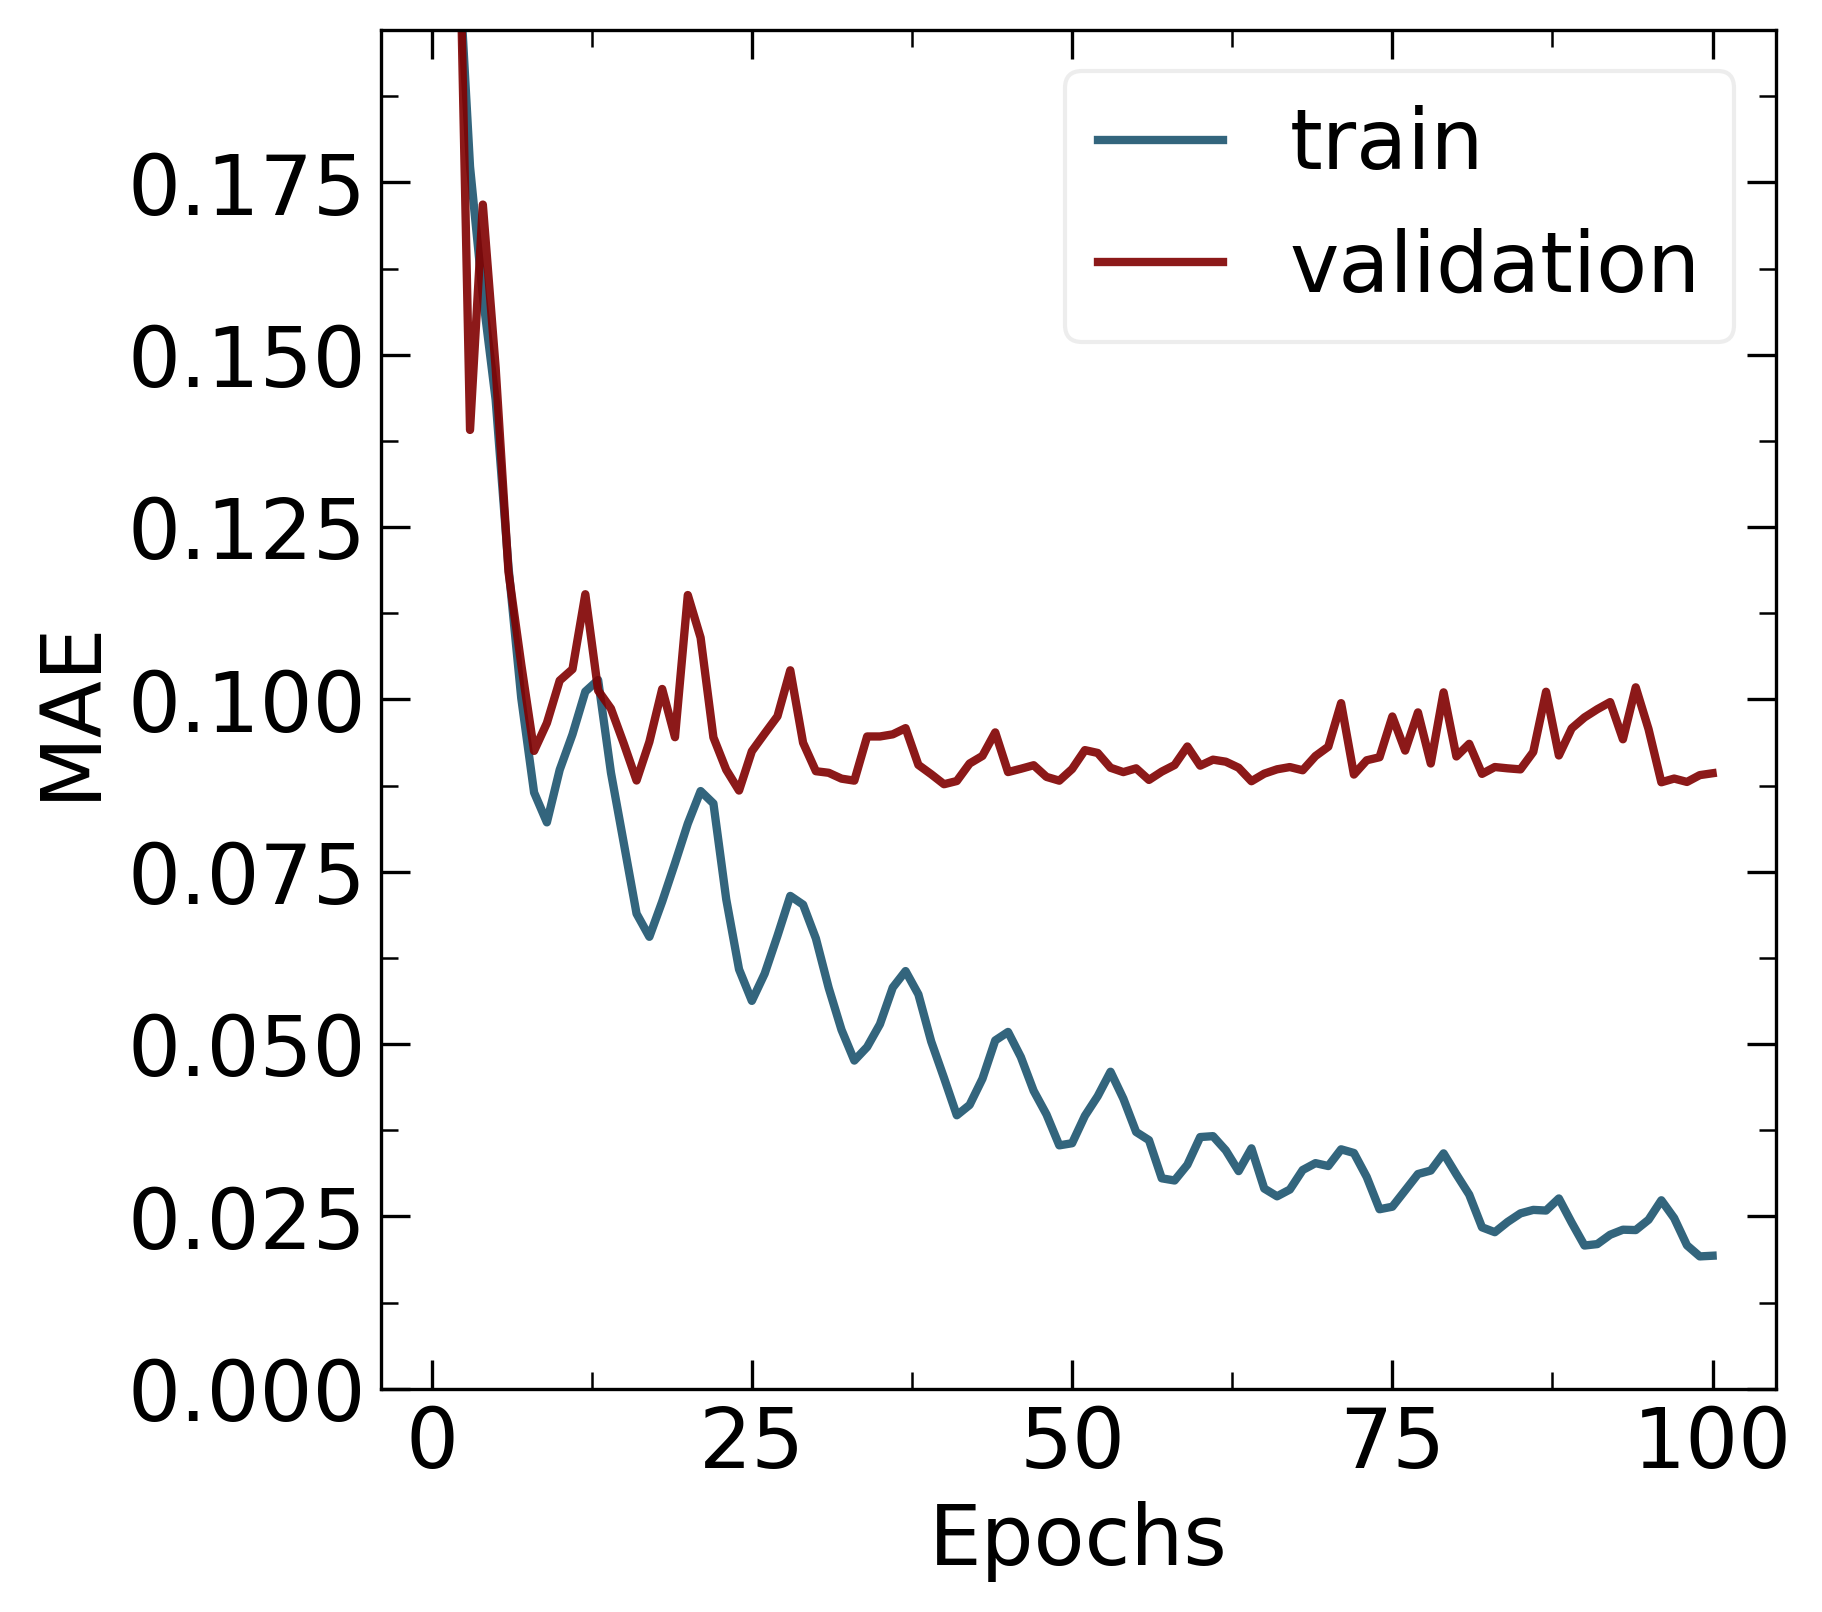

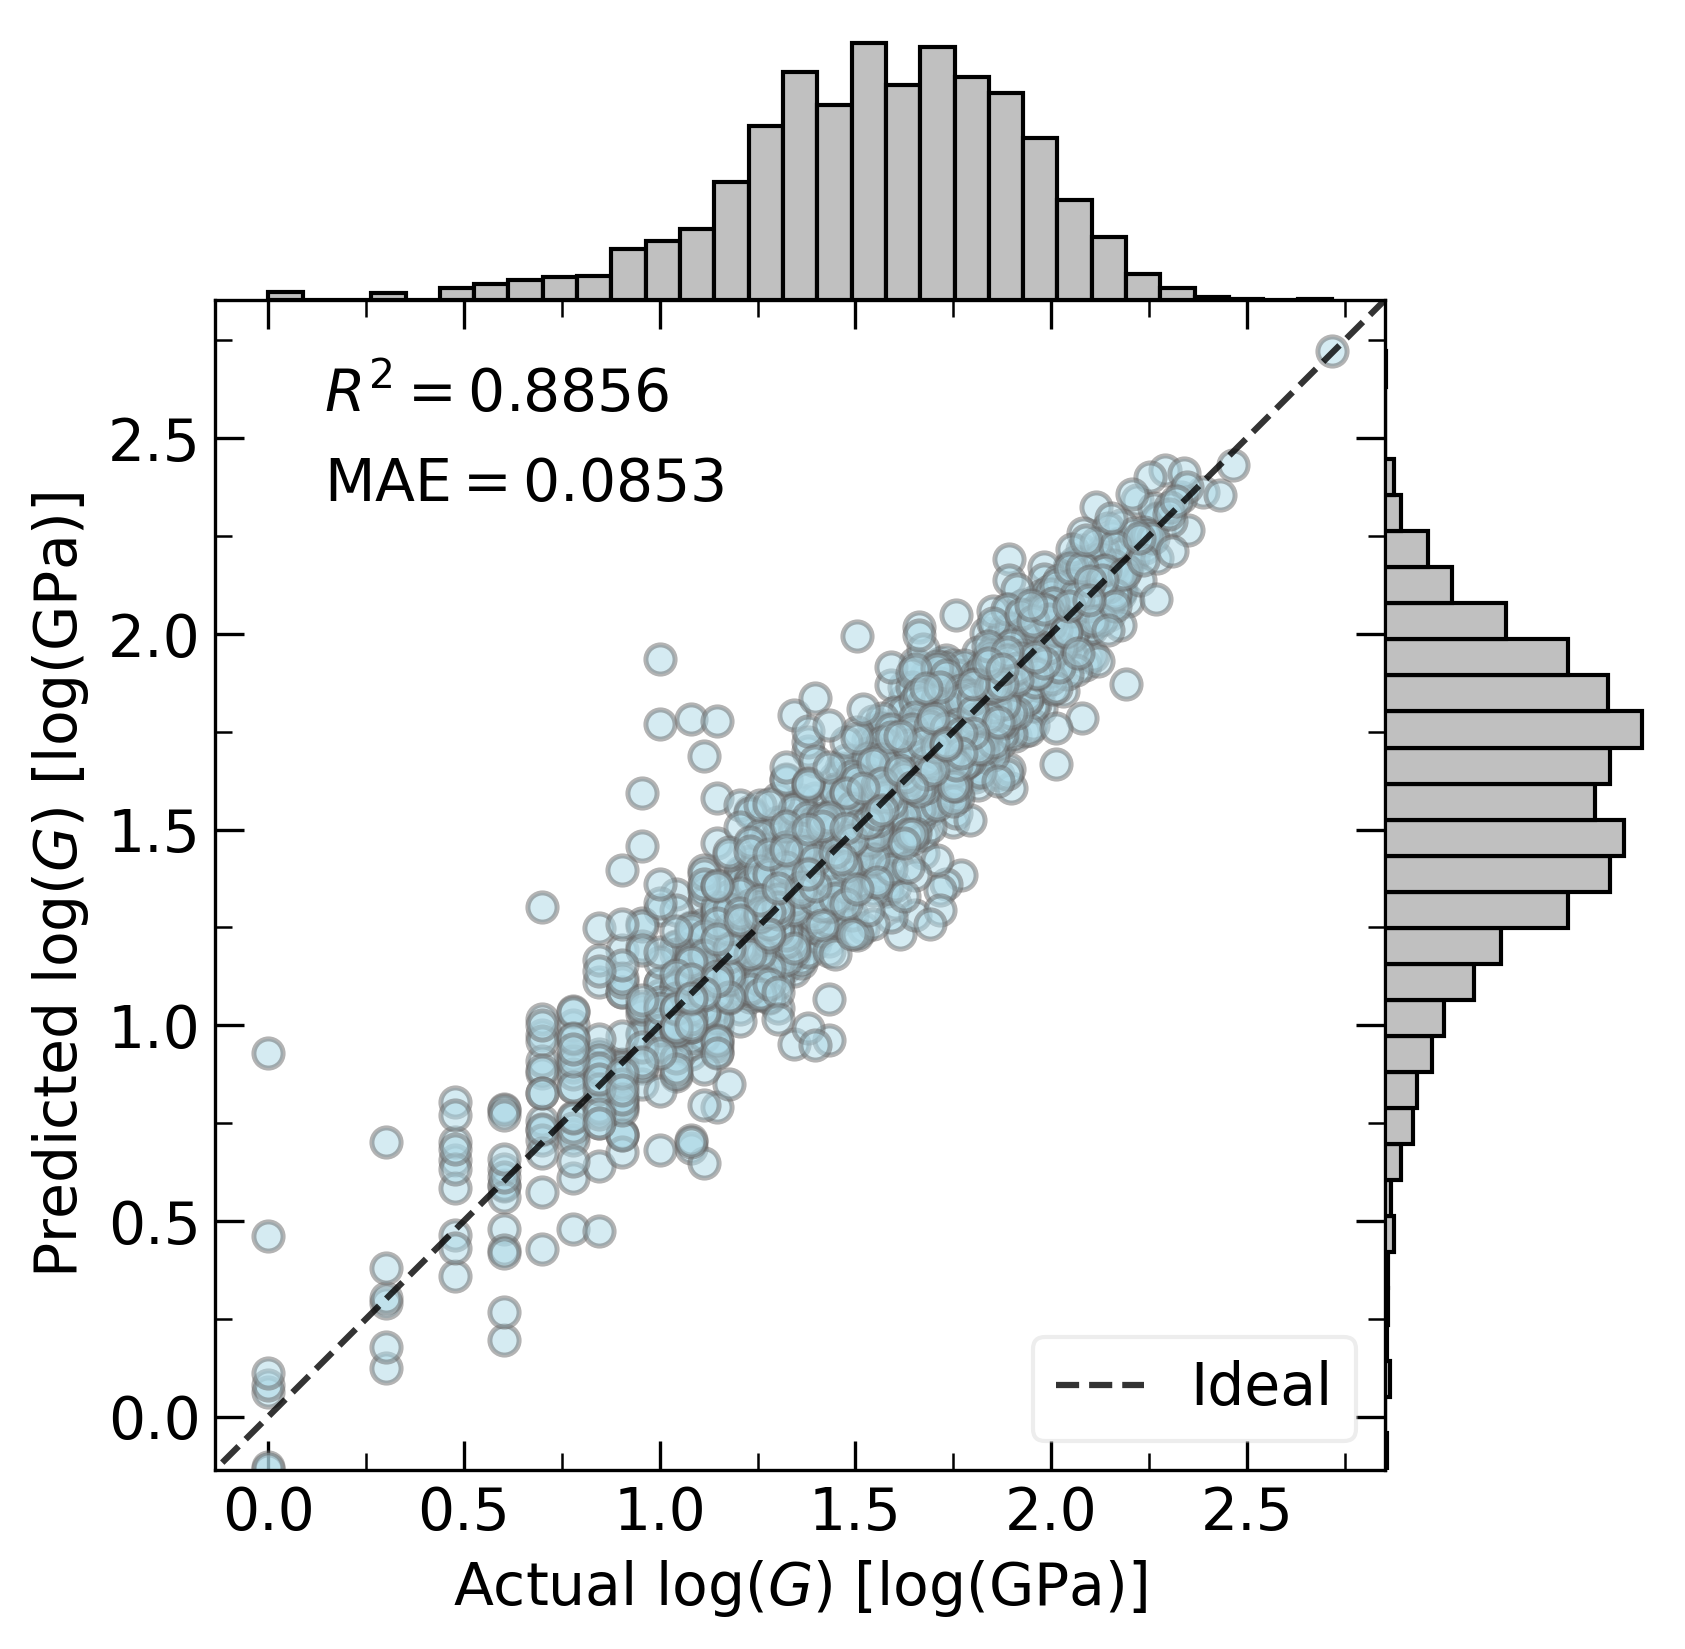

In [13]:
# Test the model and save summary
test_loader = DataLoader(mat_test, batch_size=batch_size)
actual, predicted, mae_test, r2_test = test_inference(model, test_loader)
train_val = pd.DataFrame({'epoch': e,
                          'mae_train': mae_train,
                          'mae_val': mae_val,
                          'r2_train': r2_train,
                          'r2_val': r2_val})
test_results = pd.DataFrame({'mae_test': mae_test,
                             'r2_test': r2_test},
                            index=[0])
summary = pd.concat([train_val, test_results], axis=1)
path = f'drive/My Drive/DimeNet/saves/plots/{dataset}'
date = datetime.date.today().strftime('%m-%d')
summary.to_csv(f'{path}/eighty_{dataset}_{date}.csv', index=False)
act_pred_df = pd.DataFrame({'actual': actual,
                            'predicted': predicted})
act_pred_df = pd.concat([train_val, test_results], axis=1)
act_pred_df.to_csv(f'{path}/actpred_{dataset}_{date}.csv', index=False)

# Loss curve
loss_curve(summary['epoch'], summary['mae_train'], summary['mae_val'],
           save_dir=path, name=f'eighty_{date}_{dataset}')

# Test plot
plt.rcParams.update({'font.size': 14})
act_pred(actual, predicted, target=dataset, mae=mae_test, r2=r2_test,
         save_dir=path, name=f'eighty_{date}_{dataset}')

In [14]:
df = pd.DataFrame({'iter': np.arange(0, len(rates)),
                   'lr': [i[0] for i in rates]})
df.to_csv(f'{path}/rates_{dataset}_{date}.csv', index=False)

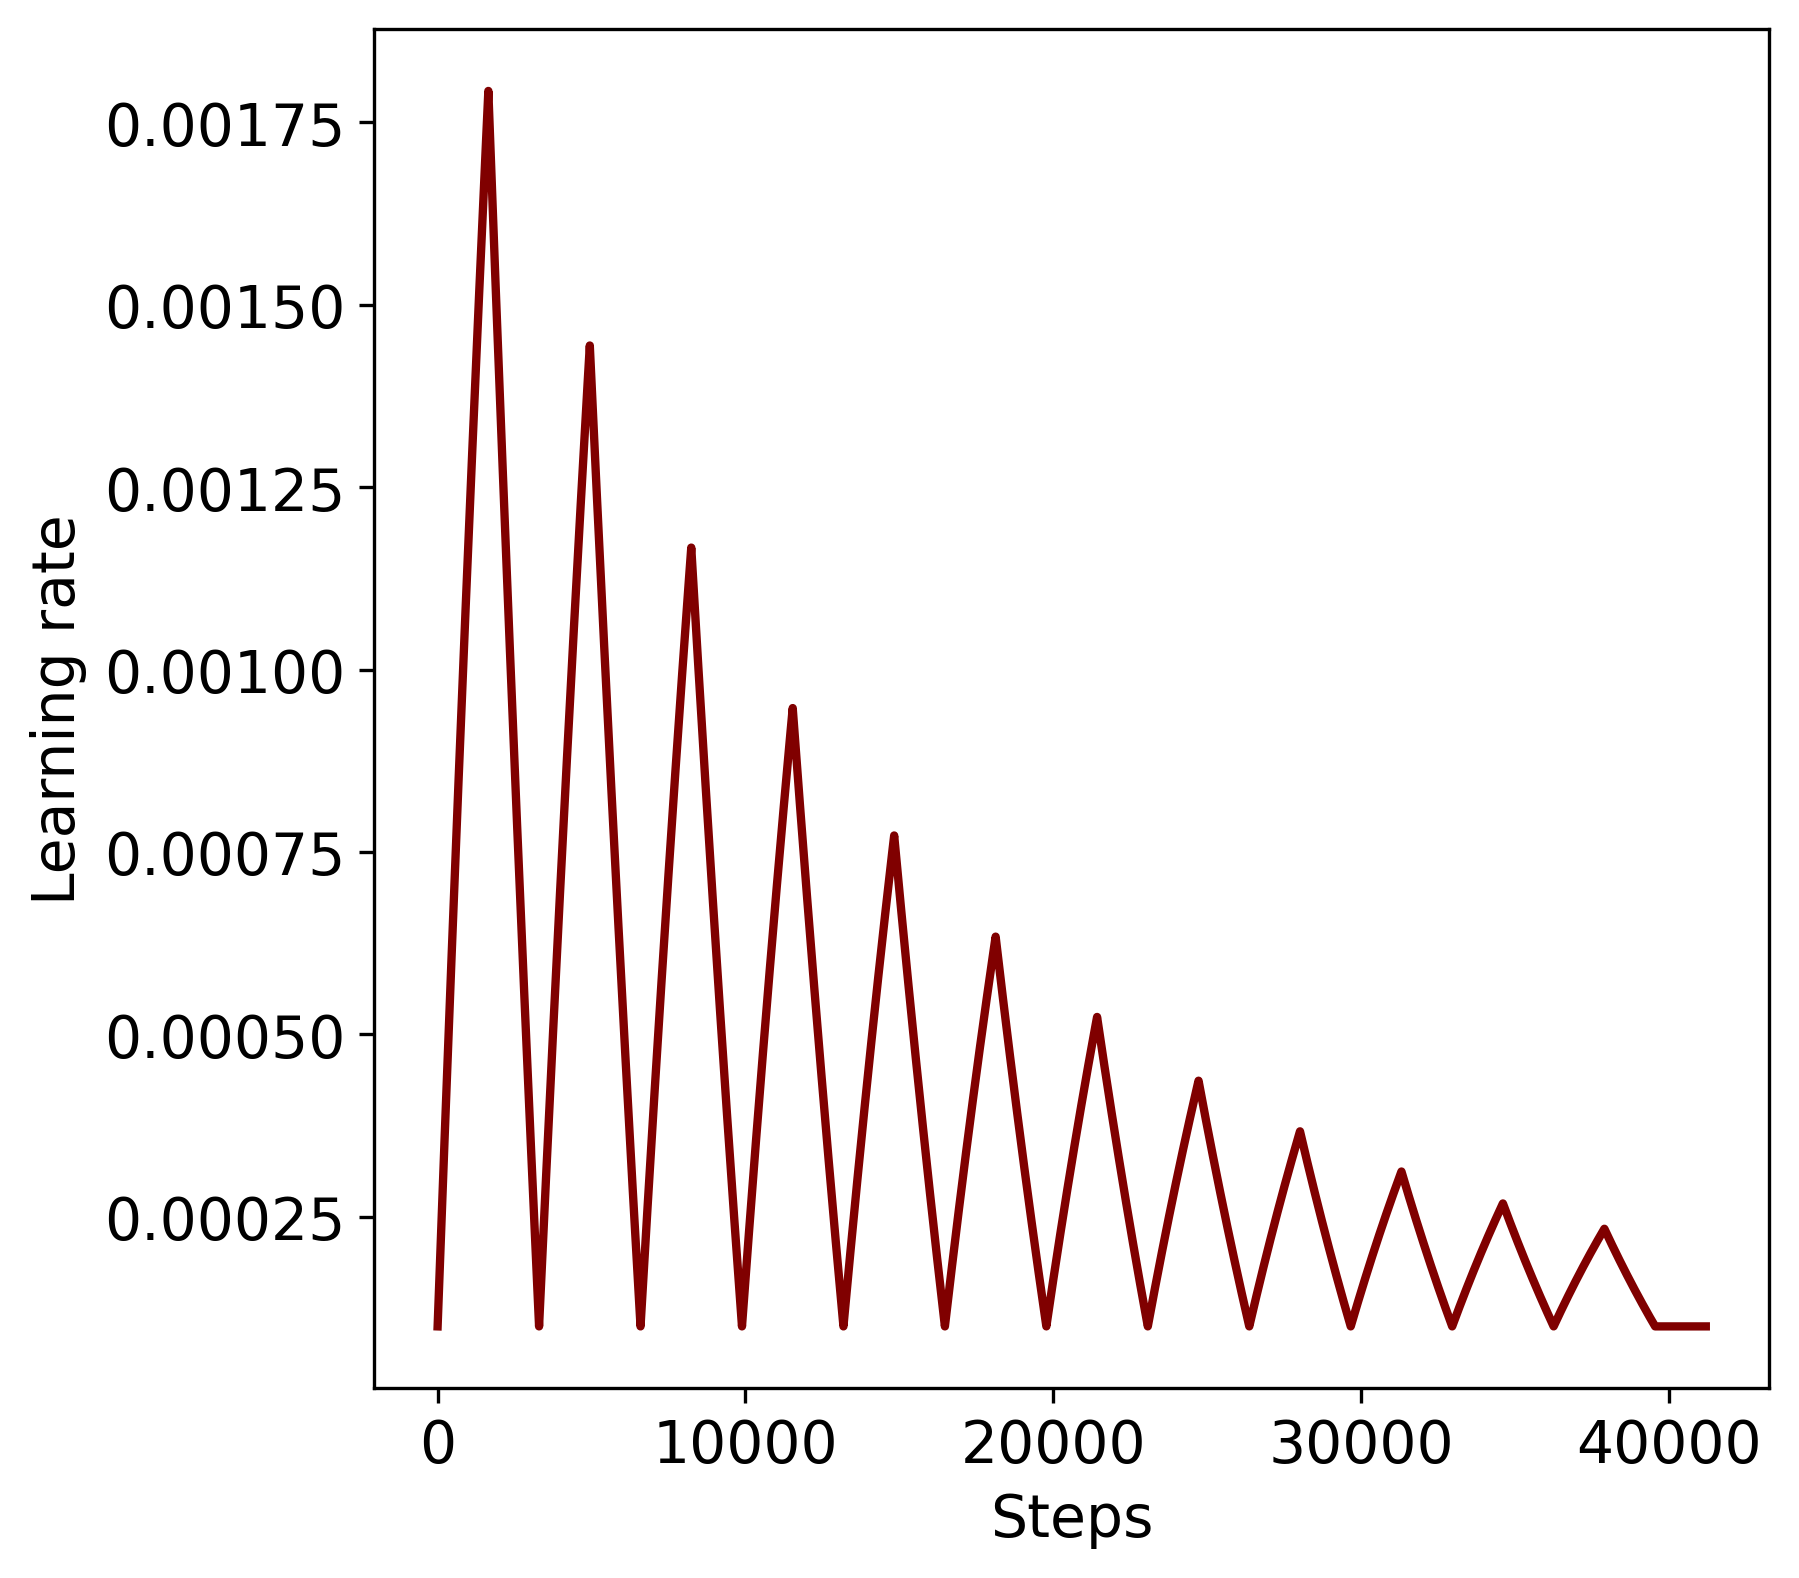

In [15]:
plt.figure(figsize=(6, 6), dpi=300)
plt.plot(df['iter'], df['lr'], '-', lw=2, color='maroon')
plt.xlabel('Steps')
plt.ylabel('Learning rate')
plt.savefig(f'{path}/rates_exp_holdoff', bbox_inches='tight', dpi=300)
plt.show()